# Simple Meta-Learning Time Series Forecasting

Following the exact mathematical specification:
1. Generate synthetic univariate series
2. Create patches with history length L and forecast horizon H
3. Normalize using global series statistics
4. Split into context and query patches for meta-learning

In [ ]:
import sys
import os

# Go up one level to project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math
from pathlib import Path

# Import custom dataset
from data.priors.LaTPFN_dataset import LaTPFNDataset
from util.config_util import ShapeConfig, dotdict

# Set random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Configuration for synthetic data generation
shape_config = ShapeConfig(
    n_context=16,
    n_sequence=500,  # Length of synthetic series
    n_features=1,    # Univariate series
    n_heldout=4,
    n_prompt=60
)

# Hyperprior parameters for realistic time series
seasonality_base = 2.0
w, m, a = seasonality_base*1, seasonality_base*2, seasonality_base*4

hyperprior_params = dotdict({
    # Seasonality parameters
    'a_min': -a, 'a_max': a, 'a_fixed_variance': 0.15,
    'm_min': -m, 'm_max': m, 'm_fixed_variance': 0.15,
    'w_min': -w, 'w_max': w, 'w_fixed_variance': 0.15,
    
    # Trend parameters
    'trend_lin_min': -0.01, 'trend_lin_max': 0.01, 'trend_lin_fixed_variance': 0.005,
    'trend_exp_min': 1 - 0.003, 'trend_exp_max': 1 + 0.003, 'trend_exp_fixed_variance': 0.001,
    'trend_exp_multiplier': 507,
    
    # Noise and resolution
    'noise_k_min': 0.5, 'noise_k_max': 3.0,
    'resolution_min': 0.1, 'resolution_max': 1.0, 'resolution_multiplier': 53.6,
    
    # Other parameters
    'harmonics_min': 4, 'harmonics_max': 8,
    'discreteness_min': 1, 'discreteness_max': 5,
    'bias_zi_min': 1, 'bias_zi_max': 5,
    'amplitude_min': 1, 'amplitude_max': 5,
    'non_negative_prob': 0.3,
    'offset_lin_min': -0.5, 'offset_lin_max': 1.0,
    'offset_exp_min': -0.5, 'offset_exp_max': 1.0,
    'f_zi_min': 0.0, 'f_zi_max': 0.8, 'f_zi_fixed_variance': 0.3
})

In [19]:
class SimpleMetaDataset:
    """
    Simple meta-task dataset.
    
    For a synthetic univariate series y_{1:T+H}, creates patches:
    - x^(t) = (y_{t-L+1}, ..., y_t) ∈ R^L (history)
    - z^(t) = (y_{t+1}, ..., y_{t+H}) ∈ R^H (forecast)
    
    Splits into context/query sets and normalizes using context series statistics.
    """
    def __init__(
        self,
        shape_config,
        hyperprior_params,
        L=20,           # Patch history length
        H=10,           # Forecast horizon
        C=8,            # Number of context patches
        Q=4,            # Number of query patches
        device="cpu"
    ):
        self.shape_config = shape_config
        self.hyperprior_params = hyperprior_params
        self.L = L  # History length
        self.H = H  # Forecast horizon
        self.C = C  # Context patches
        self.Q = Q  # Query patches
        self.device = device
        
        # Create base dataset for generating synthetic series
        self.base_dataset = LaTPFNDataset(
            shape=shape_config,
            hyperprior_params=hyperprior_params,
            batch_size=1,
            length=shape_config.n_sequence,
            is_train=False,
            device=device,
            return_components=False,
            scale_noise=False,
            separate_noise=False  # Single values only
        )
    
    def create_patches(self, series):
        """
        From a 1D series of length T, build all possible patches.

        Returns:
          patch_X : [N, L]  histories
          patch_Y : [N, H]  targets
          endpoints : [N]   index t = last time of history (so history covers [t-L+1..t])
        """
        T = len(series)
        endpoints = np.arange(self.L - 1, T - self.H, dtype=int)
        patch_X = torch.stack([series[t - self.L + 1 : t + 1] for t in endpoints], axis=0)
        patch_Y = torch.stack([series[t + 1 : t + 1 + self.H] for t in endpoints], axis=0)
        return patch_X, patch_Y, endpoints
    
    def sample_context_query_split(
        self,
        endpoints: np.ndarray,  # shape [N], history ends at t; targets are [t+1 .. t+H]
        series_length: int,     # len(y)
    ) -> tuple[np.ndarray, np.ndarray]:
        """
        Returns:
        context_patch_indices: np.ndarray of shape [self.C]
        query_patch_indices:   np.ndarray of shape [self.Q]
        Policy:
        - Context patches are fully in the first 80% by time (t + H <= split).
        - Query patches are in the last 20%. history start >= split (t - L + 1 >= split).
        """
        split_index = int(0.8 * series_length)

        # candidates by time
        ctx_candidate_indices = np.nonzero((endpoints + self.H) <= split_index)[0]
        qry_candidata_indices = np.nonzero((endpoints - self.L + 1) >= split_index)[0]

        # sample (with replace fallback if tail/head too short)
        replace_ctx = ctx_candidate_indices.size < self.C
        replace_qry = qry_candidata_indices.size < self.Q

        ctx_indices = np.random.choice(
            ctx_candidate_indices, size=self.C, replace=replace_ctx
        )
        qry_indices = np.random.choice(
            qry_candidata_indices, size=self.Q, replace=replace_qry
        )
        return ctx_indices, qry_indices

    def compute_scaler(
        self,
        patch_X: np.ndarray,
        ctx_indices: np.ndarray,
    ) -> tuple[float, float]:
        """Fit (mu, sigma) on context histories only."""
        mu = float(patch_X[ctx_indices].mean())
        sigma = float(patch_X[ctx_indices].std() + 1e-6)
        return mu, sigma
    
    def create_meta_task(self):
        """
        Create a meta-task following the specification:
        D_ctx = {(x_norm_i, z_norm_i)} for i in I_ctx
        D_qry = {x_norm_star_j} for j in I_qry
        """
        # Generate synthetic univariate series
        t, v, _ = self.base_dataset.get_a_context()
        series = v[0, :, 0]  # Extract univariate series

        T = len(series)
        # Create patches
        patches_x, patches_z, endpoints = self.create_patches(series)

        ctx_idx, qry_idx = self.sample_context_query_split(endpoints=endpoints, series_length=T)
        mu, sigma = self.compute_scaler(patches_x, ctx_idx)
        x_norm = torch.clamp((patches_x - mu) / sigma, -10.0, 10.0) 
        z_norm = torch.clamp((patches_z - mu) / sigma, -10.0, 10.0)
        
        # Create meta-task
        meta_task = {
            'ctx_x': x_norm[ctx_idx],  # Context inputs [C, L]
            'ctx_z': z_norm[ctx_idx],  # Context targets [C, H]
            'qry_x': x_norm[qry_idx],  # Query inputs [Q, L]
            'qry_z': z_norm[qry_idx],  # Query targets [Q, H]
            'stats': {'mu': mu, 'sigma': sigma},
            'raw_series': series,
            'endpoints': {'ctx': [endpoints[i] for i in ctx_idx],
                         'qry': [endpoints[i] for i in qry_idx]}
        }
        
        return meta_task

In [20]:
# Create dataset instance
dataset = SimpleMetaDataset(
    shape_config=shape_config,
    hyperprior_params=hyperprior_params,
    L=20,   # History length
    H=10,   # Forecast horizon
    C=8,    # Context patches
    Q=4,    # Query patches
    device=device
)

# Generate and visualize a sample meta-task
print("Creating sample meta-task...")
meta_task = dataset.create_meta_task()

print("\nMeta-task Structure:")
print(f"Context inputs (C, L): {meta_task['ctx_x'].shape}")
print(f"Context targets (C, H): {meta_task['ctx_z'].shape}")
print(f"Query inputs (Q, L): {meta_task['qry_x'].shape}")
print(f"Query targets (Q, H): {meta_task['qry_z'].shape}")

# Check normalization
all_normalized = torch.cat([
    meta_task['ctx_x'].flatten(),
    meta_task['ctx_z'].flatten(),
    meta_task['qry_x'].flatten(),
    meta_task['qry_z'].flatten()
])

print(f"\nNormalization Check:")
print(f"Mean: {all_normalized.mean():.4f} (should be approx 0)")
print(f"Std: {all_normalized.std():.4f} (should be approx 1)")
print(f"Series stats - mu: {meta_task['stats']['mu']:.3f}, sigma: {meta_task['stats']['sigma']:.3f}")

# Show patch endpoint information
print(f"\nPatch Endpoints:")
print(f"Context endpoints: {meta_task['endpoints']['ctx']}")
print(f"Query endpoints: {meta_task['endpoints']['qry']}")

Ignoring kwargs: <data.priors.LaTPFN_dataset.LaTPFNDataset object at 0x761144a1bee0> {}
Creating sample meta-task...

Meta-task Structure:
Context inputs (C, L): torch.Size([8, 20])
Context targets (C, H): torch.Size([8, 10])
Query inputs (Q, L): torch.Size([4, 20])
Query targets (Q, H): torch.Size([4, 10])

Normalization Check:
Mean: -0.8053 (should be approx 0)
Std: 1.5854 (should be approx 1)
Series stats - mu: 1.953, sigma: 3.923

Patch Endpoints:
Context endpoints: [271, 188, 375, 329, 49, 279, 344, 268]
Query endpoints: [477, 470, 437, 471]


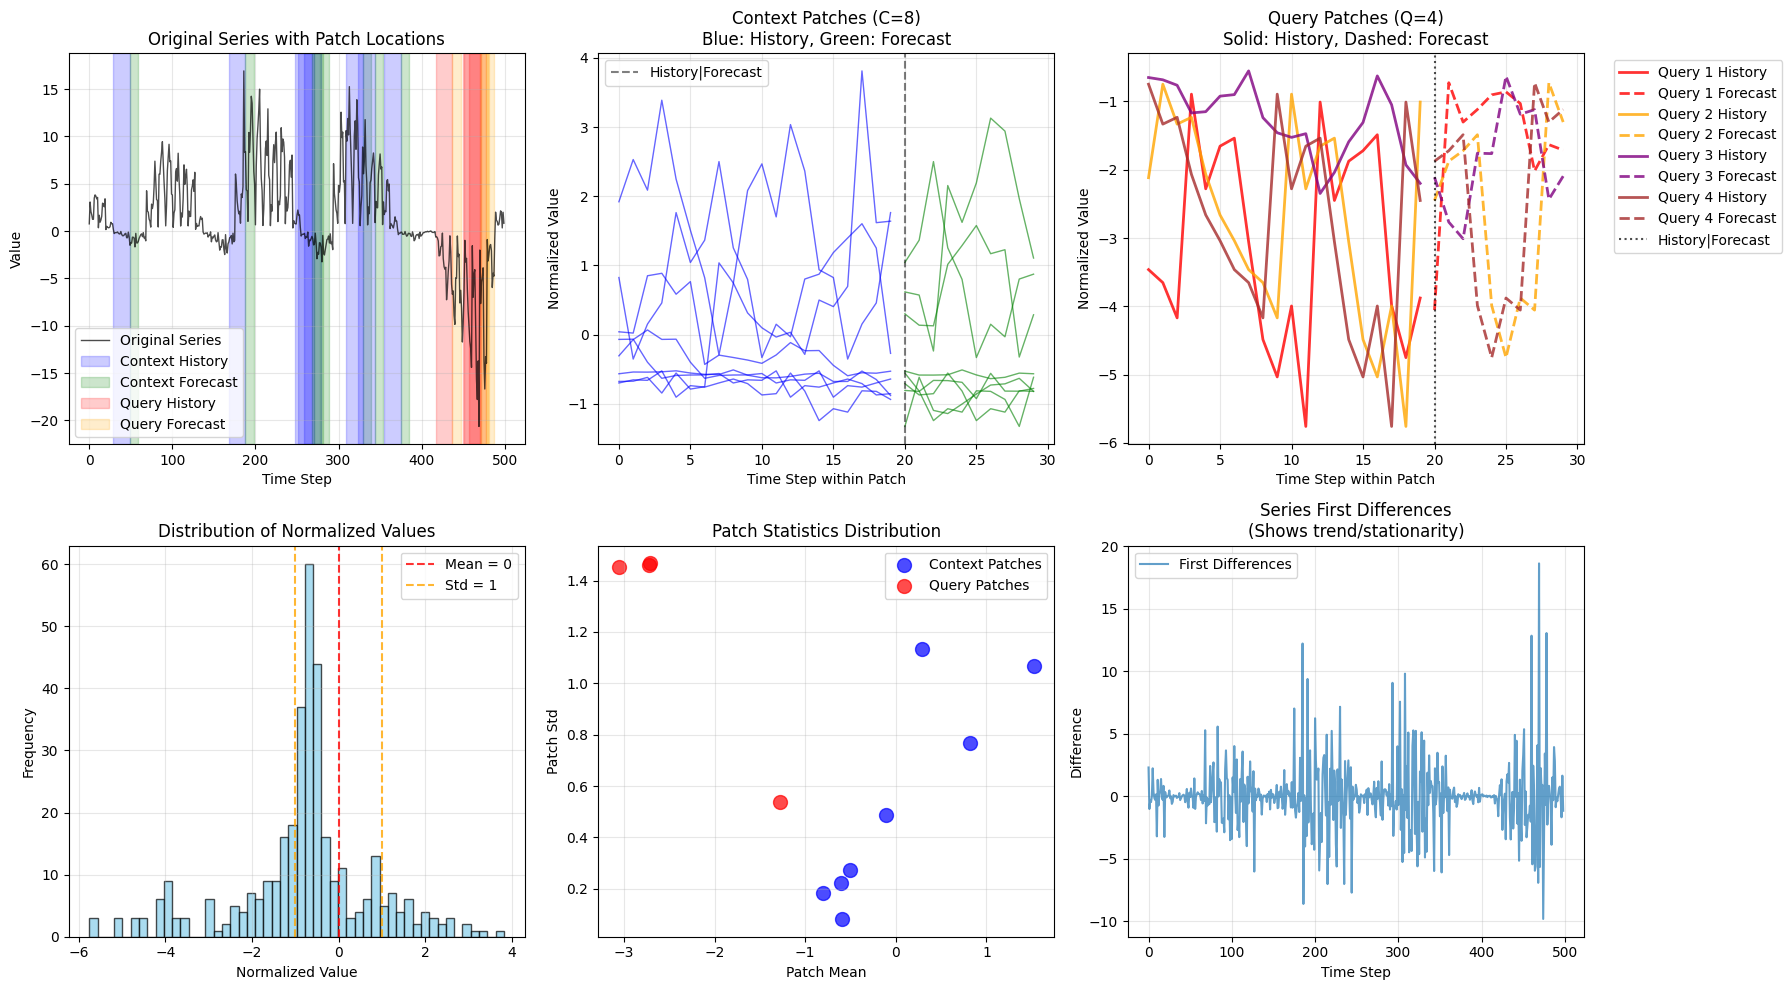


Detailed Analysis:
Original series length: 500
Number of valid patches: 12
Series range: [-20.634, 16.911]
Series trend: 0.0001 (mean first difference)
Series volatility: 2.6723 (std of first differences)

Patch Overlap Analysis:
Patch endpoints: [49, 188, 268, 271, 279, 329, 344, 375, 437, 470, 471, 477]
Minimum gap between patches: 1 steps
Patches overlap: True

Dataset Configuration:
L (history): 20, H (forecast): 10
C (context): 8, Q (query): 4
Total patches needed: 12
Available patches: 471


In [21]:
# Comprehensive visualization of the meta-task
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Original time series with patch locations
ax = axes[0, 0]
raw_series = meta_task['raw_series'].cpu()
time_points = range(len(raw_series))
ax.plot(time_points, raw_series, 'k-', alpha=0.7, linewidth=1, label='Original Series')

# Mark context patch locations
for i, endpoint in enumerate(meta_task['endpoints']['ctx']):
    start = endpoint - dataset.L
    # History patch
    ax.axvspan(start, endpoint, alpha=0.2, color='blue', label='Context History' if i == 0 else "")
    # Forecast patch
    ax.axvspan(endpoint, endpoint + dataset.H, alpha=0.2, color='green', label='Context Forecast' if i == 0 else "")

# Mark query patch locations
for i, endpoint in enumerate(meta_task['endpoints']['qry']):
    start = endpoint - dataset.L
    # History patch
    ax.axvspan(start, endpoint, alpha=0.2, color='red', label='Query History' if i == 0 else "")
    # Forecast patch
    ax.axvspan(endpoint, endpoint + dataset.H, alpha=0.2, color='orange', label='Query Forecast' if i == 0 else "")

ax.set_title('Original Series with Patch Locations')
ax.set_xlabel('Time Step')
ax.set_ylabel('Value')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Context patches (normalized)
ax = axes[0, 1]
for i in range(dataset.C):
    # History
    hist_points = range(dataset.L)
    ax.plot(hist_points, meta_task['ctx_x'][i].cpu(), 'b-', alpha=0.6, linewidth=1)
    
    # Forecast
    fore_points = range(dataset.L, dataset.L + dataset.H)
    ax.plot(fore_points, meta_task['ctx_z'][i].cpu(), 'g-', alpha=0.6, linewidth=1)

ax.axvline(x=dataset.L, color='k', linestyle='--', alpha=0.5, label='History|Forecast')
ax.set_title(f'Context Patches (C={dataset.C})\nBlue: History, Green: Forecast')
ax.set_xlabel('Time Step within Patch')
ax.set_ylabel('Normalized Value')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Query patches (normalized)
ax = axes[0, 2]
colors = ['red', 'orange', 'purple', 'brown']
for i in range(dataset.Q):
    color = colors[i % len(colors)]
    # History
    hist_points = range(dataset.L)
    ax.plot(hist_points, meta_task['qry_x'][i].cpu(), color=color, linestyle='-', alpha=0.8, linewidth=2, label=f'Query {i+1} History')
    
    # Forecast (targets)
    fore_points = range(dataset.L, dataset.L + dataset.H)
    ax.plot(fore_points, meta_task['qry_z'][i].cpu(), color=color, linestyle='--', alpha=0.8, linewidth=2, label=f'Query {i+1} Forecast')

ax.axvline(x=dataset.L, color='k', linestyle=':', alpha=0.7, label='History|Forecast')
ax.set_title(f'Query Patches (Q={dataset.Q})\nSolid: History, Dashed: Forecast')
ax.set_xlabel('Time Step within Patch')
ax.set_ylabel('Normalized Value')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

# 4. Normalization distribution
ax = axes[1, 0]
ax.hist(all_normalized.cpu().numpy(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax.axvline(x=0, color='red', linestyle='--', alpha=0.8, label='Mean = 0')
ax.axvline(x=1, color='orange', linestyle='--', alpha=0.8, label='Std = 1')
ax.axvline(x=-1, color='orange', linestyle='--', alpha=0.8)
ax.set_title('Distribution of Normalized Values')
ax.set_xlabel('Normalized Value')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Patch statistics comparison
ax = axes[1, 1]
ctx_means = meta_task['ctx_x'].mean(dim=1).cpu()
ctx_stds = meta_task['ctx_x'].std(dim=1).cpu()
qry_means = meta_task['qry_x'].mean(dim=1).cpu()
qry_stds = meta_task['qry_x'].std(dim=1).cpu()

ax.scatter(ctx_means, ctx_stds, color='blue', alpha=0.7, s=100, label='Context Patches')
ax.scatter(qry_means, qry_stds, color='red', alpha=0.7, s=100, label='Query Patches')
ax.set_xlabel('Patch Mean')
ax.set_ylabel('Patch Std')
ax.set_title('Patch Statistics Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Series characteristics
ax = axes[1, 2]
# Show some basic time series properties
raw_diff = torch.diff(raw_series)
ax.plot(raw_diff.cpu(), alpha=0.7, label='First Differences')
ax.set_title('Series First Differences\n(Shows trend/stationarity)')
ax.set_xlabel('Time Step')
ax.set_ylabel('Difference')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed analysis
print("\nDetailed Analysis:")
print(f"Original series length: {len(raw_series)}")
print(f"Number of valid patches: {len(meta_task['endpoints']['ctx']) + len(meta_task['endpoints']['qry'])}")
print(f"Series range: [{raw_series.min():.3f}, {raw_series.max():.3f}]")
print(f"Series trend: {raw_diff.mean():.4f} (mean first difference)")
print(f"Series volatility: {raw_diff.std():.4f} (std of first differences)")

print("\nPatch Overlap Analysis:")
all_endpoints = meta_task['endpoints']['ctx'] + meta_task['endpoints']['qry']
all_endpoints.sort()
print(f"Patch endpoints: {all_endpoints}")
if len(all_endpoints) > 1:
    min_gap = min(all_endpoints[i+1] - all_endpoints[i] for i in range(len(all_endpoints)-1))
    print(f"Minimum gap between patches: {min_gap} steps")
    print(f"Patches overlap: {min_gap < dataset.L}")

print(f"\nDataset Configuration:")
print(f"L (history): {dataset.L}, H (forecast): {dataset.H}")
print(f"C (context): {dataset.C}, Q (query): {dataset.Q}")
print(f"Total patches needed: {dataset.C + dataset.Q}")
print(f"Available patches: {len(raw_series) - dataset.L - dataset.H + 1}")

In [22]:
class SimpleLinearPFN(nn.Module):
    def __init__(self, L=20, H=10, d=256, L_blk=6, n_heads=8, d_ff=1024, dropout=0.1):
        super().__init__()
        self.L, self.H, self.d = L, H, d
        self.L_blk = L_blk

        # Encode [history, target] for contexts; [history, zeros(H)] for queries
        self.phi_ctx = nn.Linear(L + H, d)
        self.phi_qry = nn.Linear(L + H, d)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d, nhead=n_heads, dim_feedforward=d_ff,
            dropout=dropout, batch_first=True, norm_first=True
        )
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=L_blk)
        self.output_head = nn.Linear(d, 2 * H)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def _build_attn_mask(self, C: int, Q: int, device):
        """Boolean mask: True = disallowed. Shape [S, S] with S=C+Q."""
        S = C + Q
        mask = torch.zeros(S, S, dtype=torch.bool, device=device)
        # rows 0..C-1 (contexts): forbid attending to queries (cols C..S-1)
        mask[:C, C:] = True
        # rows C..S-1 (queries): forbid attending to queries (cols C..S-1)
        mask[C:, C:] = True   # blocks query->query (incl. self)
        return mask

    def forward(self, ctx_x, ctx_z, qry_x):
        """
        ctx_x: [B, C, L]   (normalized histories)
        ctx_z: [B, C, H]   (normalized targets)  <-- USED
        qry_x: [B, Q, L]   (normalized histories)
        """
        B, C, L = ctx_x.shape
        Q = qry_x.shape[1]
        device = ctx_x.device

        # Build inputs: contexts get their targets; queries get zeros as placeholder targets
        ctx_in = torch.cat([ctx_x, ctx_z], dim=-1)                       # [B, C, L+H]
        qry_in = torch.cat([qry_x, torch.zeros(B, Q, self.H, device=device)], dim=-1)

        ctx_e = self.phi_ctx(ctx_in)                                     # [B, C, d]
        qry_e = self.phi_qry(qry_in)                                     # [B, Q, d]
        Z0 = torch.cat([ctx_e, qry_e], dim=1)                             # [B, C+Q, d]

        # Attention mask to enforce PFN semantics
        attn_mask = self._build_attn_mask(C, Q, device)                  # [C+Q, C+Q]

        Zf = self.transformer(Z0, mask=attn_mask)                        # [B, C+Q, d]
        U = Zf[:, C:, :]                                                 # [B, Q, d]

        out = self.output_head(U)                                        # [B, Q, 2H]
        mu, log_sigma2 = out[..., :self.H], out[..., self.H:]
        return mu, log_sigma2


In [23]:
def gaussian_nll_loss(mu, log_sigma2, targets):
    """
    Compute the Gaussian negative log-likelihood loss as specified:
    
    ℓ_{j,h} = 1/2 * [ln(2π) + ln σ²_{j,h} + (z̃*_{j,h} - μ_{j,h})² / σ²_{j,h}]
    
    Task loss: L = 1/(QH) * Σ_j Σ_h ℓ_{j,h}
    
    Args:
        mu: Predicted means [batch_size, Q, H]
        log_sigma2: Predicted log variances [batch_size, Q, H]
        targets: Ground truth targets [batch_size, Q, H]
    
    Returns:
        loss: Average loss over all query patches and horizons
    """
    # Compute σ² from log σ²
    sigma2 = torch.exp(log_sigma2)
    
    # Compute loss components
    log_2pi = math.log(2 * math.pi)
    
    # ℓ_{j,h} = 1/2 * [ln(2π) + ln σ²_{j,h} + (z̃*_{j,h} - μ_{j,h})² / σ²_{j,h}]
    loss_per_point = 0.5 * (
        log_2pi +
        log_sigma2 +
        ((targets - mu) ** 2) / sigma2
    )
    
    # Average over Q queries and H horizons: 1/(QH) * Σ_j Σ_h ℓ_{j,h}
    return loss_per_point.mean()

In [16]:
# def gaussian_nll_loss(mu, log_sigma2, y):
#     # var = softplus to avoid exp under/overflow; clamp to a sane band
#     var = torch.nn.functional.softplus(log_sigma2) + 1e-6
#     var = torch.clamp(var, 1e-4, 1e2)
#     return (0.5 * (math.log(2*math.pi) + torch.log(var) + (y - mu)**2 / var)).mean()

In [24]:
# Create model instance
model = SimpleLinearPFN(
    L=dataset.L,
    H=dataset.H,
    d=256,
    L_blk=6,
    n_heads=8,
    d_ff=1024,
    dropout=0.1
).to(device)

# Model parameter count
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Architecture:")
print(f"Input dimensions: L={model.L}, H={model.H}")
print(f"Embedding dimension: d={model.d}")
print(f"Transformer blocks: L_blk={model.L_blk}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Test forward pass with sample data
print("\nTesting forward pass...")
ctx_x = meta_task['ctx_x'].unsqueeze(0).float().to(device)  # Add batch dimension
ctx_z = meta_task['ctx_z'].unsqueeze(0).float().to(device)
qry_x = meta_task['qry_x'].unsqueeze(0).float().to(device)
qry_z = meta_task['qry_z'].unsqueeze(0).float().to(device)

with torch.no_grad():
    mu, log_sigma2 = model(ctx_x, ctx_z, qry_x)
    loss = gaussian_nll_loss(mu, log_sigma2, qry_z)
    sigma = torch.exp(0.5 * log_sigma2)

print(f"Input shapes - ctx_x: {ctx_x.shape}, qry_x: {qry_x.shape}")
print(f"Output shapes - mu: {mu.shape}, log_sigma2: {log_sigma2.shape}")
print(f"Test loss: {loss.item():.4f}")
print(f"Prediction range: [{mu.min():.3f}, {mu.max():.3f}]")
print(f"Uncertainty range: [{sigma.min():.3f}, {sigma.max():.3f}]")
print(f"Target range: [{qry_z.min():.3f}, {qry_z.max():.3f}]")

Model Architecture:
Input dimensions: L=20, H=10
Embedding dimension: d=256
Transformer blocks: L_blk=6
Total parameters: 4,759,572
Trainable parameters: 4,759,572

Testing forward pass...
Input shapes - ctx_x: torch.Size([1, 8, 20]), qry_x: torch.Size([1, 4, 20])
Output shapes - mu: torch.Size([1, 4, 10]), log_sigma2: torch.Size([1, 4, 10])
Test loss: 127.1093
Prediction range: [-5.333, 5.200]
Uncertainty range: [0.093, 16.450]
Target range: [-4.750, -0.631]


/home/lvu/playground/Time-Series-Library/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [25]:
# Training Setup
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-5,
    betas=(0.9, 0.95)
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=1000,  # Total training steps
    eta_min=1e-6
)

# Training configuration
n_tasks_per_epoch = 50   # Number of meta-tasks per epoch
n_epochs = 100
log_every = 10
save_every = 20

# Create models directory
Path("models").mkdir(exist_ok=True)

# Track training metrics
train_losses = []
best_loss = float('inf')

print("Starting Meta-Learning Training...")
print(f"Training on {n_tasks_per_epoch} meta-tasks per epoch for {n_epochs} epochs")
print(f"Model has {total_params:,} parameters")
print(f"Each meta-task has C={dataset.C} context + Q={dataset.Q} query patches")

model.train()
for epoch in range(n_epochs):
    epoch_losses = []
    
    # Train on multiple meta-tasks per epoch
    for task_idx in range(n_tasks_per_epoch):
        optimizer.zero_grad()
        
        # Sample a new meta-task for each training step
        task = dataset.create_meta_task()
        
        # Prepare inputs
        ctx_x = task['ctx_x'].unsqueeze(0).float().to(device)  # [1, C, L]
        ctx_z = task['ctx_z'].unsqueeze(0).float().to(device)  # [1, C, H]
        qry_x = task['qry_x'].unsqueeze(0).float().to(device)  # [1, Q, L]
        qry_z = task['qry_z'].unsqueeze(0).float().to(device)  # [1, Q, H]
        
        # Forward pass
        mu, log_sigma2 = model(ctx_x, ctx_z, qry_x)
        
        # Compute loss: E[L(D_ctx, D_qry)]
        loss = gaussian_nll_loss(mu, log_sigma2, qry_z)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update parameters
        optimizer.step()
        scheduler.step()
        
        epoch_losses.append(loss.item())
    
    # Compute average epoch loss
    avg_loss = sum(epoch_losses) / len(epoch_losses)
    train_losses.append(avg_loss)
    
    # Track best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
            'config': {
                'L': dataset.L, 'H': dataset.H, 'C': dataset.C, 'Q': dataset.Q,
                'd': model.d, 'L_blk': model.L_blk
            }
        }, 'ckpts/best_simple_model.pt')
    
    # Logging and evaluation
    if (epoch + 1) % log_every == 0 or epoch == 0:
        current_lr = scheduler.get_last_lr()[0]
        print(f"\nEpoch [{epoch+1}/{n_epochs}]")
        print(f"Training Loss: {avg_loss:.4f}, LR: {current_lr:.2e}")
        
        # Quick evaluation on test tasks
        model.eval()
        test_losses = []
        test_correlations = []
        
        with torch.no_grad():
            for _ in range(10):  # Evaluate on 10 test tasks
                test_task = dataset.create_meta_task()
                test_ctx_x = test_task['ctx_x'].unsqueeze(0).float().to(device)
                test_ctx_z = test_task['ctx_z'].unsqueeze(0).float().to(device)
                test_qry_x = test_task['qry_x'].unsqueeze(0).float().to(device)
                test_qry_z = test_task['qry_z'].unsqueeze(0).float().to(device)
                
                test_mu, test_log_sigma2 = model(test_ctx_x, test_ctx_z, test_qry_x)
                test_loss = gaussian_nll_loss(test_mu, test_log_sigma2, test_qry_z)
                test_losses.append(test_loss.item())
                
                # Compute correlation
                pred_flat = test_mu.flatten()
                true_flat = test_qry_z.flatten()
                if len(pred_flat) > 1:
                    corr = torch.corrcoef(torch.stack([pred_flat, true_flat]))[0, 1]
                    if not torch.isnan(corr):
                        test_correlations.append(corr.item())
        
        avg_test_loss = sum(test_losses) / len(test_losses)
        avg_test_corr = sum(test_correlations) / len(test_correlations) if test_correlations else 0.0
        
        print(f"Test Loss: {avg_test_loss:.4f}")
        print(f"Test Correlation: {avg_test_corr:.3f}")
        
        model.train()
    
    # Save checkpoint
    if (epoch + 1) % save_every == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, f'ckpts/simple_model_epoch_{epoch+1}.pt')

print(f"\nTraining completed!")
print(f"Best loss: {best_loss:.4f}")
print(f"Final loss: {train_losses[-1]:.4f}")
print(f"Improvement: {(train_losses[0] - train_losses[-1]) / train_losses[0] * 100:.1f}%")

Starting Meta-Learning Training...
Training on 50 meta-tasks per epoch for 100 epochs
Model has 4,759,572 parameters
Each meta-task has C=8 context + Q=4 query patches

Epoch [1/100]
Training Loss: 2354.7926, LR: 9.94e-05
Test Loss: 4.3455
Test Correlation: 0.043

Epoch [10/100]
Training Loss: 3.5699, LR: 5.05e-05
Test Loss: 2.6456
Test Correlation: 0.273

Epoch [20/100]
Training Loss: 2.3643, LR: 1.00e-06
Test Loss: 2.4743
Test Correlation: 0.305

Epoch [30/100]
Training Loss: 2.8402, LR: 5.05e-05
Test Loss: 1.9600
Test Correlation: 0.079

Epoch [40/100]
Training Loss: 2.7513, LR: 1.00e-04
Test Loss: 2.3085
Test Correlation: 0.204

Epoch [50/100]
Training Loss: 2.2989, LR: 5.05e-05
Test Loss: 1.9843
Test Correlation: 0.080

Epoch [60/100]
Training Loss: 2.2812, LR: 1.00e-06
Test Loss: 2.2527
Test Correlation: 0.307

Epoch [70/100]
Training Loss: 2.2494, LR: 5.05e-05
Test Loss: 2.4231
Test Correlation: 0.337

Epoch [80/100]
Training Loss: 2.6062, LR: 1.00e-04
Test Loss: 2.2552
Test Cor


Final Evaluation Results:
Average Test NLL: 2.1456 ± 1.0859
Average Test MSE: 6.1288 ± 5.5865
Average Correlation: 0.330 ± 0.367


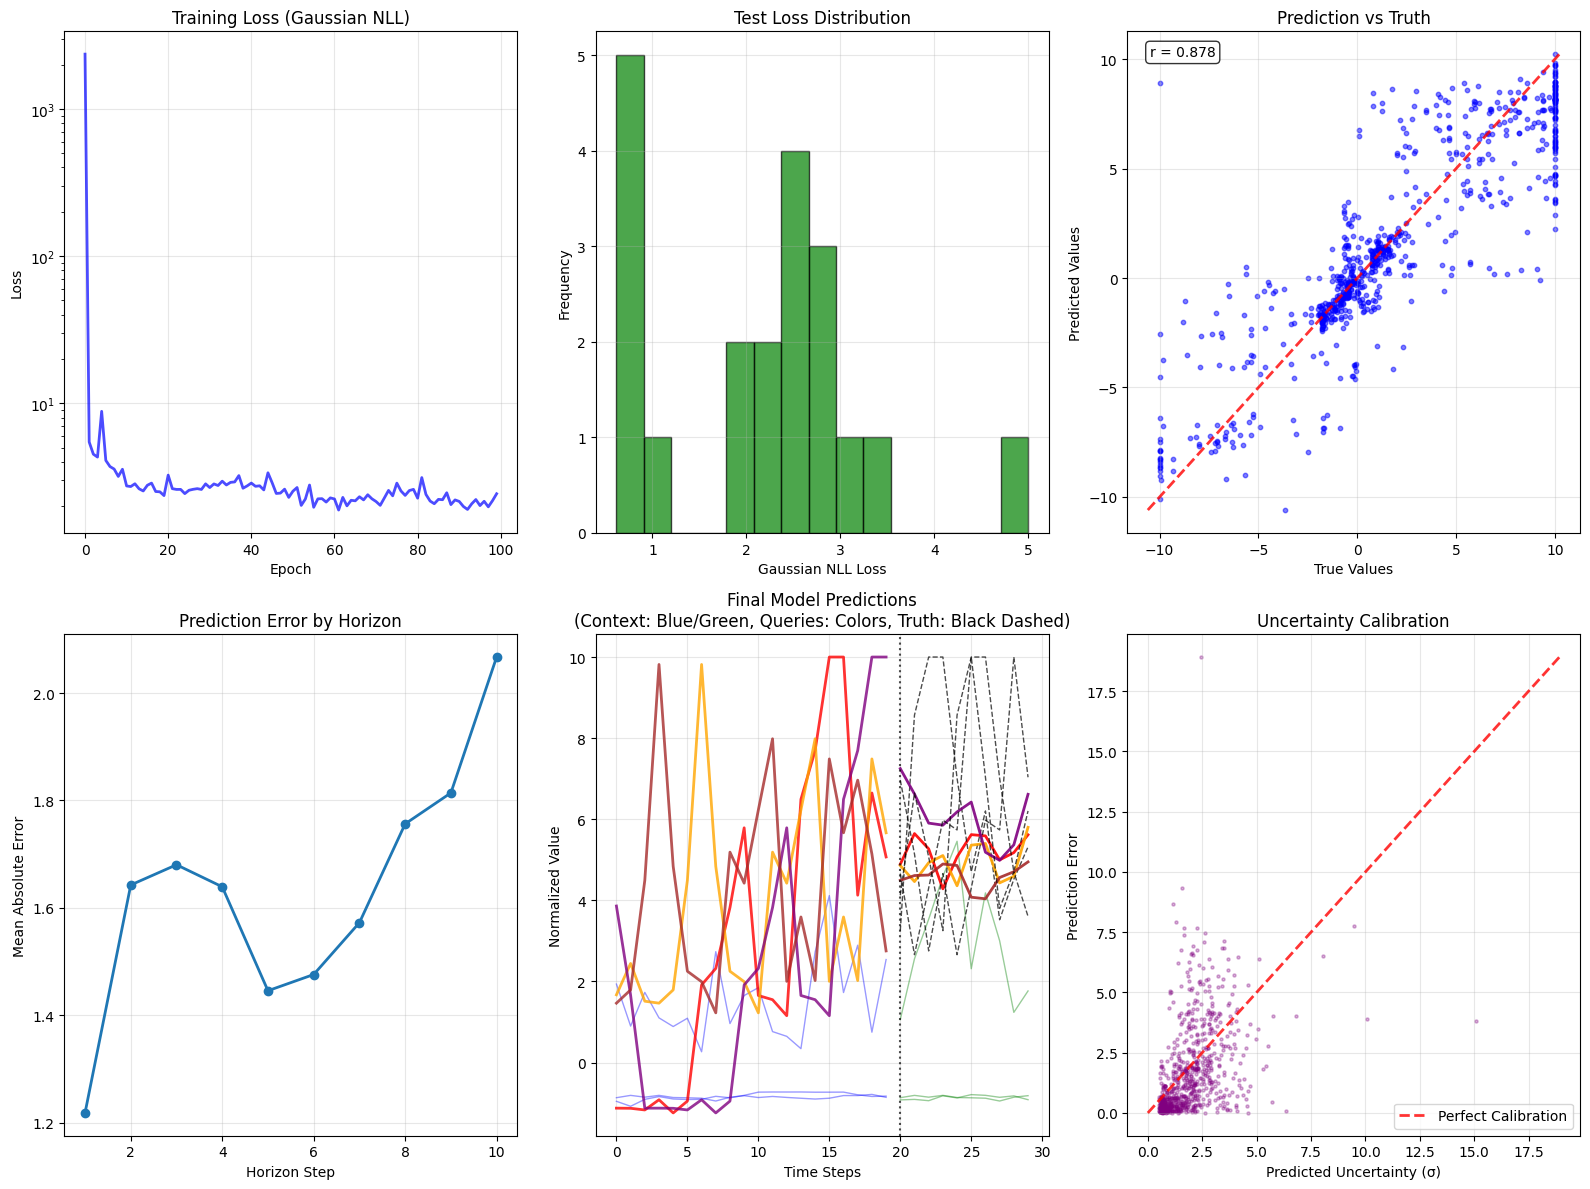


Comprehensive Analysis:
Training epochs: 100
Best training loss: 1.8865
Final correlation: 0.878
Error growth from horizon 1 to 10: 1.70x
Correlation: 0.878 (>0.5 is good)
Model saved to: ckpts/best_simple_model.pt
Architecture: L=20, H=10, C=8, Q=4, d=256
Parameters: 4,759,572


In [26]:
# Evaluate the trained model and visualize results
plt.figure(figsize=(16, 12))

# 1. Training loss curve
plt.subplot(2, 3, 1)
plt.plot(train_losses, 'b-', alpha=0.7, linewidth=2)
plt.title('Training Loss (Gaussian NLL)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.yscale('log')

# 2. Load best model and evaluate on multiple test tasks
model.load_state_dict(torch.load('ckpts/best_simple_model.pt')['model_state_dict'])
model.eval()

n_test_tasks = 20
test_results = {
    'losses': [], 'mses': [], 'correlations': [],
    'predictions': [], 'targets': [], 'uncertainties': []
}

with torch.no_grad():
    for _ in range(n_test_tasks):
        # Generate test task
        test_task = dataset.create_meta_task()
        ctx_x = test_task['ctx_x'].unsqueeze(0).float().to(device)
        ctx_z = test_task['ctx_z'].unsqueeze(0).float().to(device)
        qry_x = test_task['qry_x'].unsqueeze(0).float().to(device)
        qry_z = test_task['qry_z'].unsqueeze(0).float().to(device)
        
        # Make predictions
        mu, log_sigma2 = model(ctx_x, ctx_z, qry_x)
        sigma = torch.exp(0.5 * log_sigma2)
        
        # Compute metrics
        nll_loss = gaussian_nll_loss(mu, log_sigma2, qry_z)
        mse_loss = F.mse_loss(mu, qry_z)
        
        # Correlation
        pred_flat = mu.flatten()
        true_flat = qry_z.flatten()
        if len(pred_flat) > 1:
            corr = torch.corrcoef(torch.stack([pred_flat, true_flat]))[0, 1]
            if not torch.isnan(corr):
                test_results['correlations'].append(corr.item())
        
        test_results['losses'].append(nll_loss.item())
        test_results['mses'].append(mse_loss.item())
        test_results['predictions'].append(mu.cpu())
        test_results['targets'].append(qry_z.cpu())
        test_results['uncertainties'].append(sigma.cpu())

# Combine results
all_predictions = torch.cat(test_results['predictions'], dim=0)
all_targets = torch.cat(test_results['targets'], dim=0)
all_uncertainties = torch.cat(test_results['uncertainties'], dim=0)

print("\nFinal Evaluation Results:")
print(f"Average Test NLL: {np.mean(test_results['losses']):.4f} ± {np.std(test_results['losses']):.4f}")
print(f"Average Test MSE: {np.mean(test_results['mses']):.4f} ± {np.std(test_results['mses']):.4f}")
print(f"Average Correlation: {np.mean(test_results['correlations']):.3f} ± {np.std(test_results['correlations']):.3f}")

# 2. Test loss distribution
plt.subplot(2, 3, 2)
plt.hist(test_results['losses'], bins=15, alpha=0.7, color='green', edgecolor='black')
plt.title('Test Loss Distribution')
plt.xlabel('Gaussian NLL Loss')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 3. Prediction vs target scatter
plt.subplot(2, 3, 3)
pred_flat = all_predictions.flatten()
target_flat = all_targets.flatten()
plt.scatter(target_flat, pred_flat, alpha=0.5, s=10, color='blue')
min_val = min(target_flat.min(), pred_flat.min())
max_val = max(target_flat.max(), pred_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Prediction vs Truth')
plt.grid(True, alpha=0.3)

# Overall correlation
overall_corr = torch.corrcoef(torch.stack([target_flat, pred_flat]))[0, 1]
plt.text(0.05, 0.95, f'r = {overall_corr:.3f}', transform=plt.gca().transAxes,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Error by horizon step
plt.subplot(2, 3, 4)
errors_by_horizon = []
for h in range(dataset.H):
    horizon_error = (all_predictions[:, :, h] - all_targets[:, :, h]).abs().mean()
    errors_by_horizon.append(horizon_error.item())

plt.plot(range(1, dataset.H + 1), errors_by_horizon, 'o-', linewidth=2, markersize=6)
plt.title('Prediction Error by Horizon')
plt.xlabel('Horizon Step')
plt.ylabel('Mean Absolute Error')
plt.grid(True, alpha=0.3)

# 5. Show example predictions from trained model
plt.subplot(2, 3, 5)
# Get one final test example
final_task = dataset.create_meta_task()
ctx_x = final_task['ctx_x'].unsqueeze(0).float().to(device)
ctx_z = final_task['ctx_z'].unsqueeze(0).float().to(device)
qry_x = final_task['qry_x'].unsqueeze(0).float().to(device)
qry_z = final_task['qry_z'].unsqueeze(0).float().to(device)

with torch.no_grad():
    final_mu, final_log_sigma2 = model(ctx_x, ctx_z, qry_x)
    final_sigma = torch.exp(0.5 * final_log_sigma2)

# Plot context (first few for clarity)
for i in range(min(3, dataset.C)):
    ctx_times = range(dataset.L)
    plt.plot(ctx_times, ctx_x[0, i].cpu(), 'b-', alpha=0.4, linewidth=1)
    future_times = range(dataset.L, dataset.L + dataset.H)
    plt.plot(future_times, ctx_z[0, i].cpu(), 'g-', alpha=0.4, linewidth=1)

# Plot query predictions
colors = ['red', 'orange', 'purple', 'brown']
for i in range(dataset.Q):
    color = colors[i % len(colors)]
    qry_times = range(dataset.L)
    plt.plot(qry_times, qry_x[0, i].cpu(), color=color, linestyle='-', alpha=0.8, linewidth=2)
    
    pred_times = range(dataset.L, dataset.L + dataset.H)
    plt.plot(pred_times, final_mu[0, i].cpu(), color=color, linestyle='-', alpha=0.9, linewidth=2)
    plt.plot(pred_times, qry_z[0, i].cpu(), color='black', linestyle='--', alpha=0.7, linewidth=1)

plt.axvline(x=dataset.L, color='k', linestyle=':', alpha=0.7)
plt.title('Final Model Predictions\n(Context: Blue/Green, Queries: Colors, Truth: Black Dashed)')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Value')
plt.grid(True, alpha=0.3)

# 6. Uncertainty calibration
plt.subplot(2, 3, 6)
pred_errors = (all_predictions - all_targets).abs()
error_flat = pred_errors.flatten()
uncertainty_flat = all_uncertainties.flatten()

plt.scatter(uncertainty_flat, error_flat, alpha=0.3, s=5, color='purple')
plt.xlabel('Predicted Uncertainty (σ)')
plt.ylabel('Prediction Error')
plt.title('Uncertainty Calibration')
plt.grid(True, alpha=0.3)

# Ideal calibration line
max_val = max(uncertainty_flat.max(), error_flat.max())
plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.8, linewidth=2, label='Perfect Calibration')
plt.legend()

plt.tight_layout()
plt.show()

# Print comprehensive analysis
print(f"\nComprehensive Analysis:")
print(f"Training epochs: {len(train_losses)}")
print(f"Best training loss: {min(train_losses):.4f}")
print(f"Final correlation: {overall_corr:.3f}")
print(f"Error growth from horizon 1 to {dataset.H}: {errors_by_horizon[-1]/errors_by_horizon[0]:.2f}x")

print(f"Correlation: {overall_corr:.3f} (>0.5 is good)")

print(f"Model saved to: ckpts/best_simple_model.pt")
print(f"Architecture: L={dataset.L}, H={dataset.H}, C={dataset.C}, Q={dataset.Q}, d={model.d}")
print(f"Parameters: {total_params:,}")

In [27]:
import copy
# Test new PFN model with Q=1 (single query)
print("Testing new PFN model with Q=1...")

# Create a Q=1 dataset
dataset_q1 = SimpleMetaDataset(shape_config=shape_config,
                                   hyperprior_params=hyperprior_params,
                                   L=20, H=10, C=10, Q=1, device=device
)

model_q1 = copy.deepcopy(model)

print(f"Q=1 Model Architecture: L={model_q1.L}, H={model_q1.H}, d={model_q1.d}")
print(f"Parameters: {sum(p.numel() for p in model_q1.parameters()):,}")

# Test with Q=1 meta-task
task_q1 = dataset_q1.create_meta_task()
print(f"\nQ=1 Meta-task shapes:")
print(f"Context inputs (C, L): {task_q1['ctx_x'].shape}")
print(f"Context targets (C, H): {task_q1['ctx_z'].shape}")
print(f"Query inputs (Q, L): {task_q1['qry_x'].shape}")
print(f"Query targets (Q, H): {task_q1['qry_z'].shape}")

# Forward pass test
ctx_x_q1 = task_q1['ctx_x'].unsqueeze(0).float().to(device)  # [1, C, L]
ctx_z_q1 = task_q1['ctx_z'].unsqueeze(0).float().to(device)  # [1, C, H]
qry_x_q1 = task_q1['qry_x'].unsqueeze(0).float().to(device)  # [1, Q, L]
qry_z_q1 = task_q1['qry_z'].unsqueeze(0).float().to(device)  # [1, Q, H]

print(f"\nBatch shapes:")
print(f"ctx_x: {ctx_x_q1.shape} (normalized histories)")
print(f"ctx_z: {ctx_z_q1.shape} (normalized targets)")
print(f"qry_x: {qry_x_q1.shape} (query history)")
print(f"qry_z: {qry_z_q1.shape} (query target for loss)")

with torch.no_grad():
    mu_q1, log_sigma2_q1 = model_q1(ctx_x_q1, ctx_z_q1, qry_x_q1)
    loss_q1 = gaussian_nll_loss(mu_q1, log_sigma2_q1, qry_z_q1)
    sigma_q1 = torch.exp(0.5 * log_sigma2_q1)

print(f"\nForward pass results:")
print(f"Output shapes - mu: {mu_q1.shape}, log_sigma2: {log_sigma2_q1.shape}")
print(f"Test loss: {loss_q1.item():.4f}")
print(f"Prediction range: [{mu_q1.min():.3f}, {mu_q1.max():.3f}]")
print(f"Uncertainty range: [{sigma_q1.min():.3f}, {sigma_q1.max():.3f}]")

Testing new PFN model with Q=1...
Ignoring kwargs: <data.priors.LaTPFN_dataset.LaTPFNDataset object at 0x7611448ba110> {}
Q=1 Model Architecture: L=20, H=10, d=256
Parameters: 4,759,572

Q=1 Meta-task shapes:
Context inputs (C, L): torch.Size([10, 20])
Context targets (C, H): torch.Size([10, 10])
Query inputs (Q, L): torch.Size([1, 20])
Query targets (Q, H): torch.Size([1, 10])

Batch shapes:
ctx_x: torch.Size([1, 10, 20]) (normalized histories)
ctx_z: torch.Size([1, 10, 10]) (normalized targets)
qry_x: torch.Size([1, 1, 20]) (query history)
qry_z: torch.Size([1, 1, 10]) (query target for loss)

Forward pass results:
Output shapes - mu: torch.Size([1, 1, 10]), log_sigma2: torch.Size([1, 1, 10])
Test loss: 2.4145
Prediction range: [3.035, 4.433]
Uncertainty range: [1.924, 3.424]


Generating Q=1 visualizations...


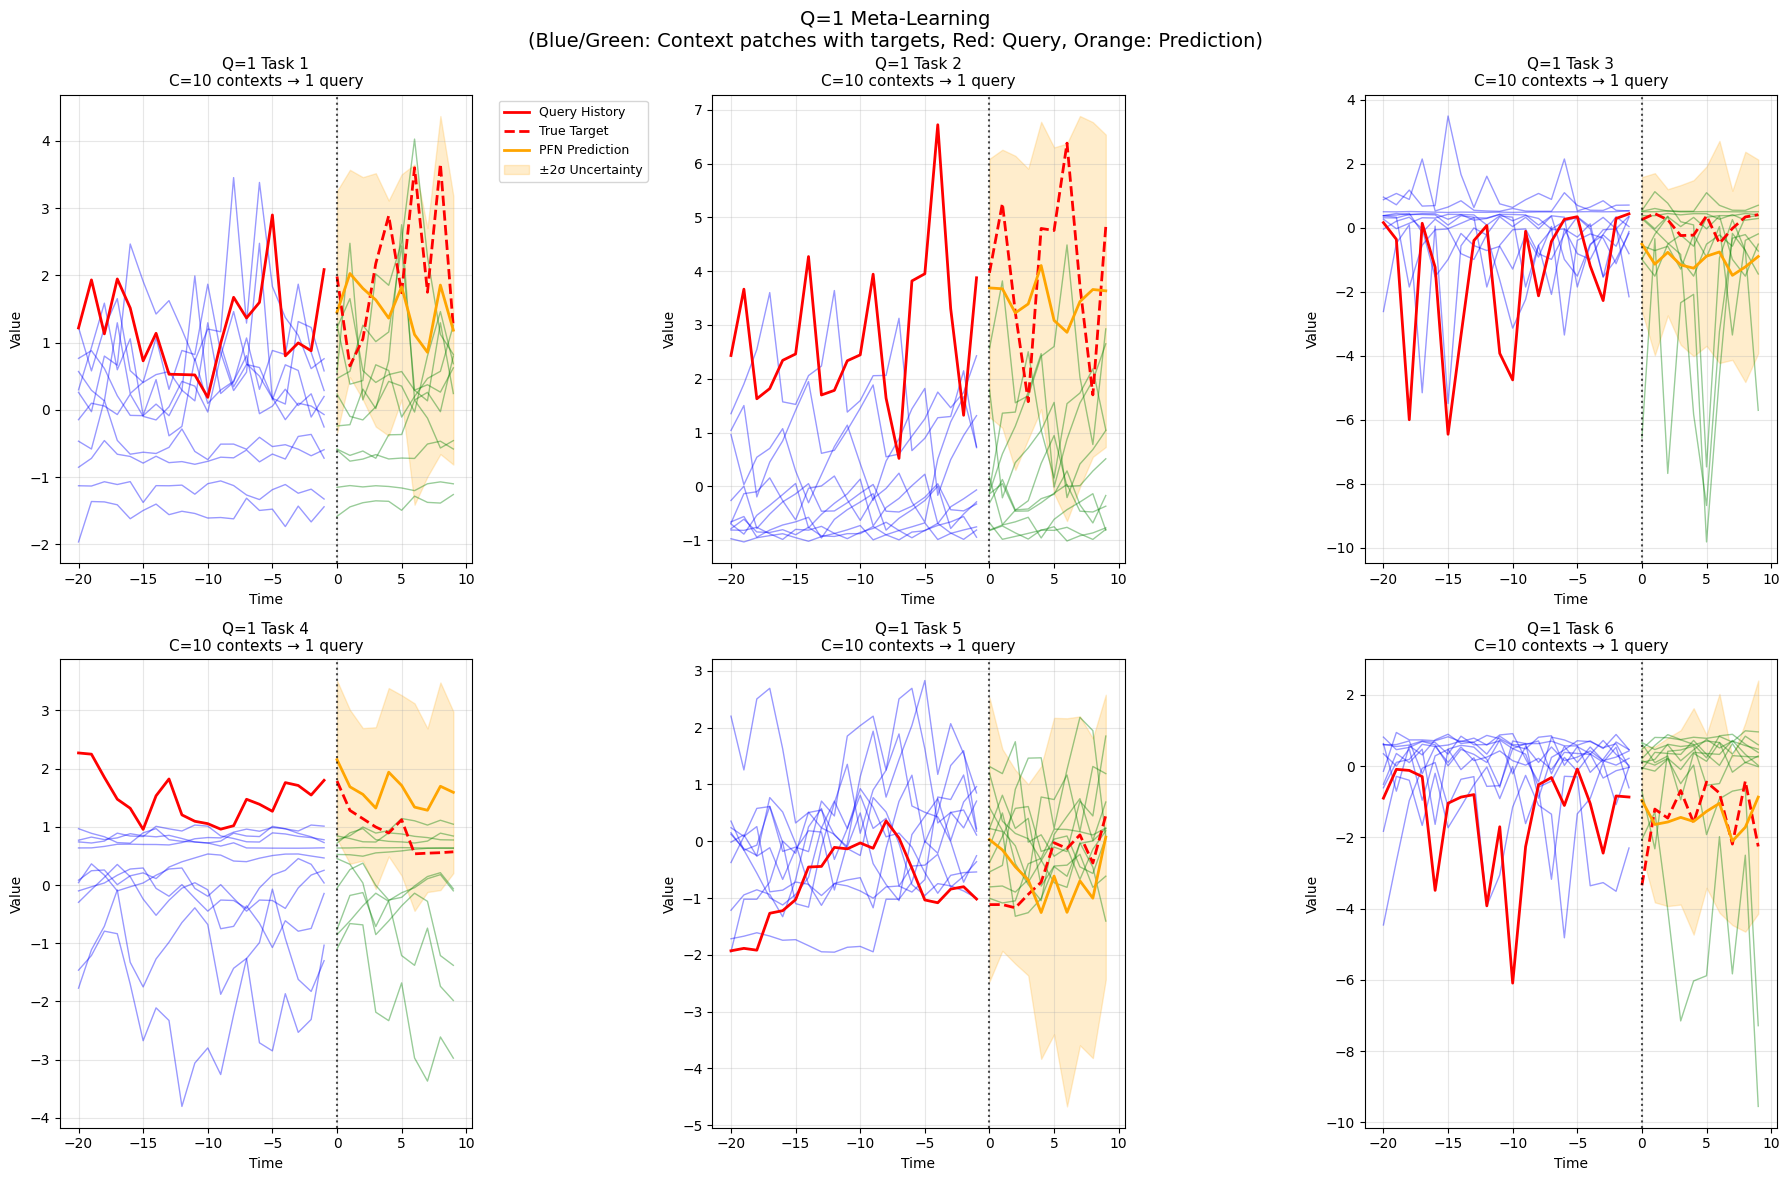

In [28]:
# Create multiple Q=1 test tasks for visualization
n_visual_tasks = 6
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

print("Generating Q=1 visualizations...")

model_q1.eval()
with torch.no_grad():
    for i in range(n_visual_tasks):
        # Create a new Q=1 meta-task
        task = dataset_q1.create_meta_task()
        
        # Prepare inputs
        ctx_x = task['ctx_x'].unsqueeze(0).float().to(device)  # [1, C, L]
        ctx_z = task['ctx_z'].unsqueeze(0).float().to(device)  # [1, C, H]
        qry_x = task['qry_x'].unsqueeze(0).float().to(device)  # [1, Q, L] with Q=1
        qry_z = task['qry_z'].unsqueeze(0).float().to(device)  # [1, Q, H] with Q=1
        
        # Forward pass through your new PFN
        mu, log_sigma2 = model_q1(ctx_x, ctx_z, qry_x)
        sigma = torch.exp(0.5 * log_sigma2)
        
        # Convert to CPU for plotting
        ctx_x_plot = ctx_x[0].cpu()  # [C, L]
        ctx_z_plot = ctx_z[0].cpu()  # [C, H]
        qry_x_plot = qry_x[0].cpu()  # [1, L]
        qry_z_plot = qry_z[0].cpu()  # [1, H]
        mu_plot = mu[0].cpu()        # [1, H]
        sigma_plot = sigma[0].cpu()  # [1, H]
        
        ax = axes[i]
        
        # Time axes
        hist_times = range(-dataset_q1.L, 0)
        fore_times = range(0, dataset_q1.H)
        
        # Plot context examples (C=5 patches)
        for c in range(dataset_q1.C):
            # Context history
            ax.plot(hist_times, ctx_x_plot[c], 'b-', alpha=0.4, linewidth=1)
            # Context targets (what the model sees!)
            ax.plot(fore_times, ctx_z_plot[c], 'g-', alpha=0.4, linewidth=1)
        
        # Plot query
        # Query history  
        ax.plot(hist_times, qry_x_plot[0], 'r-', linewidth=2, label='Query History')
        # True query target
        ax.plot(fore_times, qry_z_plot[0], 'r--', linewidth=2, label='True Target')
        # Model prediction
        ax.plot(fore_times, mu_plot[0], 'orange', linewidth=2, label='PFN Prediction')
        
        # Uncertainty bands
        upper = mu_plot[0] + 2 * sigma_plot[0]
        lower = mu_plot[0] - 2 * sigma_plot[0]
        ax.fill_between(fore_times, lower, upper, alpha=0.2, color='orange', label='±2σ Uncertainty')
        
        # Styling
        ax.axvline(x=0, color='black', linestyle=':', alpha=0.7)
        ax.set_title(f'Q=1 Task {i+1}\nC={dataset_q1.C} contexts → 1 query', fontsize=11)
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.grid(True, alpha=0.3)
        
        if i == 0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

plt.suptitle('Q=1 Meta-Learning\n(Blue/Green: Context patches with targets, Red: Query, Orange: Prediction)', 
             fontsize=14, y=0.98)
plt.tight_layout()
plt.show()


In [30]:
# ===== EXTEND ORIGINAL DATASET FOR VARIABLE C,Q =====
import math

class VariableMetaDataset(SimpleMetaDataset):
    """
    Extension of SimpleMetaDataset with variable C,Q.
    Preserves all original functionality while adding support for variable context/query sizes.
    """
    
    def __init__(
        self,
        shape_config,
        hyperprior_params,
        L=50,           # History length
        H=20,           # Forecast horizon  
        C_range=(4, 256),  # Variable context range
        Q_range=(1, 16),   # Variable query range
        device="cpu",
        sample_log_uniform=True
    ):
        # Initialize with maximum C,Q for internal consistency
        max_C = C_range[1] if isinstance(C_range, tuple) else C_range
        max_Q = Q_range[1] if isinstance(Q_range, tuple) else Q_range
        
        # Call parent with max sizes
        super().__init__(
            shape_config=shape_config,
            hyperprior_params=hyperprior_params,
            L=L, H=H, C=max_C, Q=max_Q,
            device=device
        )
        
        # Store variable sampling configuration
        self.C_range = C_range
        self.Q_range = Q_range
        self.sample_log_uniform = sample_log_uniform
        
        print(f"Variable SimpleMetaTaskDataset:")
        print(f"  L={L}, H={H}")
        print(f"  C range: {C_range} ({'log-uniform' if sample_log_uniform else 'uniform'})")
        print(f"  Q range: {Q_range}")
        print(f"  Max patches needed: C={max_C}, Q={max_Q}")
    
    def _sample_C(self):
        """Sample context size C using log-uniform or uniform distribution"""
        if isinstance(self.C_range, tuple):
            min_C, max_C = self.C_range
            if self.sample_log_uniform:
                # Log-uniform sampling (TabPFN style)
                log_min, log_max = math.log(min_C), math.log(max_C)
                log_C = np.random.uniform(log_min, log_max)
                return min(max_C, max(min_C, int(math.exp(log_C))))
            else:
                return np.random.randint(min_C, max_C + 1)
        else:
            return self.C_range
    
    def _sample_Q(self):
        """Sample query size Q using uniform distribution"""
        if isinstance(self.Q_range, tuple):
            min_Q, max_Q = self.Q_range
            return np.random.randint(min_Q, max_Q + 1)
        else:
            return self.Q_range
    
    def sample_context_query_split(self, endpoints: np.ndarray, series_len: int, C_actual=None, Q_actual=None):
        """
        Override parent method to support variable C,Q sizes.
        Sample disjoint index sets with actual sizes.
        """
        # C_use = C_actual if C_actual is not None else self.C
        # Q_use = Q_actual if Q_actual is not None else self.Q
        
        # if n_patches < C_use + Q_use:
        #     raise ValueError(f"Not enough patches ({n_patches}) for C={C_use} + Q={Q_use}")
        
        # all_indices = torch.randperm(n_patches)
        # ctx_indices = all_indices[:C_use]
        # qry_indices = all_indices[C_use:C_use + Q_use]
        
        # return ctx_indices, qry_indices
        split = int(0.8 * series_len)
        C_use = C_actual if C_actual is not None else self.C
        Q_use = Q_actual if Q_actual is not None else self.Q

        ctx_cand = np.nonzero((endpoints + self.H) <= split)[0]
        qry_cand = np.nonzero((endpoints - self.L + 1) >= split)[0]

        rep_c = ctx_cand.size < C_use
        rep_q = qry_cand.size < Q_use

        # If *no* candidates exist, relax minimally by borrowing across split.
        if ctx_cand.size == 0:
            ctx_cand = np.arange(len(endpoints))
            rep_c = True
        if qry_cand.size == 0:
            qry_cand = np.arange(len(endpoints))
            rep_q = True

        ctx_idx = np.random.choice(ctx_cand, size=C_use, replace=rep_c)
        qry_idx = np.random.choice(qry_cand, size=Q_use, replace=rep_q)

        # Ensure disjoint sets; if collision happens under replacement, fix greedily.
        if rep_c or rep_q:
            ctx_set = set(ctx_idx.tolist())
            q_fixed = []
            for q in qry_idx:
                if q in ctx_set:
                    # pick a new one from qry_cand not in ctx_set if possible
                    pool = [x for x in qry_cand if x not in ctx_set]
                    q = np.random.choice(pool) if len(pool) else q
                q_fixed.append(q)
            qry_idx = np.array(q_fixed, dtype=int)

        return ctx_idx, qry_idx
    
    def create_meta_task(self):
        """
        Create meta-task with variable C,Q sizes.
        Preserves all original functionality from your implementation.
        """
        # Sample actual sizes for this task
        C_actual = self._sample_C()
        Q_actual = self._sample_Q()
        
        t, v, _ = self.base_dataset.get_a_context()
        y_series = v[0, :, 0]  # Extract univariate series
        
        patches_x, patches_z, endpoints = self.create_patches(y_series)
        endpoints_np = np.asarray(endpoints, dtype=int)
        
        # x_norm, z_norm, mu, sigma = self.normalize_patches(patches_x, patches_z, y_series)
        
        # Sample context/query split with actual sizes
        ctx_idx, qry_idx = self.sample_context_query_split(endpoints_np, len(y_series), C_actual, Q_actual)
        # ctx_indices, qry_indices = self.sample_context_query_split(
        #     len(patches_x), C_actual, Q_actual
        # )
        mu, sigma = self.compute_scaler(patches_x, ctx_idx)
        
        x_norm = torch.clamp((patches_x - mu) / sigma, -10.0, 10.0)
        z_norm = torch.clamp((patches_z - mu) / sigma, -10.0, 10.0)
        
        # Create meta-task (your original structure)
        meta_task = {
            'ctx_x': x_norm[ctx_idx],  # Context inputs [C_actual, L]
            'ctx_z': z_norm[ctx_idx],  # Context targets [C_actual, H]
            'qry_x': x_norm[qry_idx],  # Query inputs [Q_actual, L]
            'qry_z': z_norm[qry_idx],  # Query targets [Q_actual, H]
            'stats': {'mu': mu, 'sigma': sigma},
            'raw_series': y_series,
            'endpoints': {'ctx': [endpoints[i] for i in ctx_idx],
                         'qry': [endpoints[i] for i in qry_idx]}
        }
        
        return meta_task

# Create variable dataset
dataset_variable = VariableMetaDataset(
    shape_config=shape_config,
    hyperprior_params=hyperprior_params,
    L=50, H=20,
    C_range=(4, 64),
    Q_range=(1, 8),
    device=device,
    sample_log_uniform=True
)

# Test variable sampling
print("\nTesting variable C,Q sampling:")
for i in range(5):
    task = dataset_variable.create_meta_task()
    C_actual = task['ctx_x'].shape[0]
    Q_actual = task['qry_x'].shape[0]
    print(f"  Sample {i+1}: C={C_actual}, Q={Q_actual}")
    print(f"    Series stats: μ={task['stats']['mu']:.3f}, σ={task['stats']['sigma']:.3f}")

Ignoring kwargs: <data.priors.LaTPFN_dataset.LaTPFNDataset object at 0x76114431f400> {}
Variable SimpleMetaTaskDataset:
  L=50, H=20
  C range: (4, 64) (log-uniform)
  Q range: (1, 8)
  Max patches needed: C=64, Q=8

Testing variable C,Q sampling:
  Sample 1: C=24, Q=8
    Series stats: μ=5.729, σ=4.977
  Sample 2: C=31, Q=6
    Series stats: μ=-4.841, σ=21.329
  Sample 3: C=11, Q=6
    Series stats: μ=1.727, σ=1.957
  Sample 4: C=7, Q=2
    Series stats: μ=-107.944, σ=294.017
  Sample 5: C=35, Q=3
    Series stats: μ=-0.606, σ=4.159


In [31]:
# ===== SCALED TRAINING: 500K TASKS =====

model_scaled = SimpleLinearPFN(
    L=dataset_variable.L,
    H=dataset_variable.H,
    d=512,      # Large embedding
    L_blk=12,   # Deep transformer
    n_heads=16, # Many attention heads
    d_ff=2048,  # Large feedforward
    dropout=0.1
).to(device)

scaled_params = sum(p.numel() for p in model_scaled.parameters())
print(f"Scaled Model: {scaled_params:,} parameters")

# Scaled training configuration (500K tasks)
scaled_config = {
    'total_tasks': 500_000,          # 500K tasks
    'tasks_per_epoch': 5_000,        # 5K tasks per epoch  
    'validate_every': 10,            # Validate every 10 epochs
    'save_every': 20,                # Save every 20 epochs
    'log_every': 500,                # Log every 500 tasks
    'n_val_tasks': 100,              # Validation tasks
    'early_stopping_patience': 20,   # Patience for 500K training
    'warmup_tasks': 5_000,           # LR warmup period
}

n_epochs = scaled_config['total_tasks'] // scaled_config['tasks_per_epoch']
estimated_time = scaled_config['total_tasks'] * 3.6 / 10_000 / 60

print(f"\nTraining Plan:")
print(f"  Total meta-tasks: {scaled_config['total_tasks']:,}")
print(f"  Tasks per epoch: {scaled_config['tasks_per_epoch']:,}")
print(f"  Total epochs: {n_epochs}")
print(f"  Variable C: {dataset_variable.C_range} (log-uniform)")
print(f"  Variable Q: {dataset_variable.Q_range}")
print(f"  Estimated time: ~{estimated_time:.0f} hours")

# Optimizer following TabPFN principles
optimizer_scaled = torch.optim.AdamW(
    model_scaled.parameters(),
    lr=3e-4,
    weight_decay=1e-4,
    betas=(0.9, 0.95)
)

# Learning rate schedule with warmup and cosine decay
def get_scaled_lr_schedule(optimizer, warmup_tasks, total_tasks):
    def lr_lambda(step):
        if step < warmup_tasks:
            return step / warmup_tasks
        else:
            progress = (step - warmup_tasks) / (total_tasks - warmup_tasks)
            return 0.1 + 0.9 * 0.5 * (1 + np.cos(np.pi * progress))  # Decay to 10%
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler_scaled = get_scaled_lr_schedule(
    optimizer_scaled, 
    scaled_config['warmup_tasks'], 
    scaled_config['total_tasks']
)

print("✓ 500K task training setup ready!")
print("✓ Using extended SimpleMetaDataset with LaTPFN prior")
print("✓ Variable C,Q sampling for better generalization")

Scaled Model: 37,921,832 parameters

Training Plan:
  Total meta-tasks: 500,000
  Tasks per epoch: 5,000
  Total epochs: 100
  Variable C: (4, 64) (log-uniform)
  Variable Q: (1, 8)
  Estimated time: ~3 hours
✓ 500K task training setup ready!
✓ Using extended SimpleMetaDataset with LaTPFN prior
✓ Variable C,Q sampling for better generalization


/home/lvu/playground/Time-Series-Library/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [32]:
# ===== 500K TRAINING EXECUTION =====
import time
from collections import defaultdict

print("STARTING 500K TASK TRAINING")

# Enhanced validation for variable C,Q
def validate_model(model, dataset, n_val_tasks=100):
    """Validation with variable C,Q sizes using your dataset"""
    model.eval()
    val_metrics = {'loss': [], 'correlation': [], 'C_sizes': [], 'Q_sizes': []}
    
    with torch.no_grad():
        for _ in range(n_val_tasks):
            task = dataset.create_meta_task()
            
            # Get actual sizes
            C_actual = task['ctx_x'].shape[0] 
            Q_actual = task['qry_x'].shape[0]
            
            ctx_x = task['ctx_x'].unsqueeze(0).float().to(device)
            ctx_z = task['ctx_z'].unsqueeze(0).float().to(device)
            qry_x = task['qry_x'].unsqueeze(0).float().to(device)
            qry_z = task['qry_z'].unsqueeze(0).float().to(device)
            
            # Forward pass
            mu, log_sigma2 = model(ctx_x, ctx_z, qry_x)
            loss = gaussian_nll_loss(mu, log_sigma2, qry_z)
            val_metrics['loss'].append(loss.item())
            
            # Correlation
            mu_flat = mu.flatten().cpu()
            qry_z_flat = qry_z.flatten().cpu()
            corr = torch.corrcoef(torch.stack([mu_flat, qry_z_flat]))[0, 1]
            if not torch.isnan(corr):
                val_metrics['correlation'].append(corr.item())
            
            val_metrics['C_sizes'].append(C_actual)
            val_metrics['Q_sizes'].append(Q_actual)
    
    model.train()
    return {
        'loss': np.mean(val_metrics['loss']),
        'loss_std': np.std(val_metrics['loss']),
        'correlation': np.mean(val_metrics['correlation']) if val_metrics['correlation'] else 0.0,
        'correlation_std': np.std(val_metrics['correlation']) if val_metrics['correlation'] else 0.0,
        'avg_C': np.mean(val_metrics['C_sizes']),
        'avg_Q': np.mean(val_metrics['Q_sizes']),
        'C_range': f"{min(val_metrics['C_sizes'])}-{max(val_metrics['C_sizes'])}",
        'Q_range': f"{min(val_metrics['Q_sizes'])}-{max(val_metrics['Q_sizes'])}"
    }

# Training tracking
scaled_history = defaultdict(list)
best_val_loss = float('inf')
patience_counter = 0
start_time = time.time()
global_task_count = 0

# Initial validation
print("Running initial validation...")
val_metrics = validate_model(model_scaled, dataset_variable, scaled_config['n_val_tasks'])
print(f"Initial validation - Loss: {val_metrics['loss']:.4f}, Corr: {val_metrics['correlation']:.3f}")
print(f"Initial C range: {val_metrics['C_range']}, Q range: {val_metrics['Q_range']}")

# 500K training loop
model_scaled.train()

for epoch in range(n_epochs):
    epoch_start = time.time()
    epoch_losses = []
    epoch_C_sizes = []
    epoch_Q_sizes = []
    
    for task_idx in range(scaled_config['tasks_per_epoch']):
        optimizer_scaled.zero_grad()
        
        # Create meta-task with variable C,Q
        task = dataset_variable.create_meta_task()
        
        # Track sizes
        C_actual = task['ctx_x'].shape[0]
        Q_actual = task['qry_x'].shape[0]
        epoch_C_sizes.append(C_actual)
        epoch_Q_sizes.append(Q_actual)
        
        ctx_x = task['ctx_x'].unsqueeze(0).float().to(device)
        ctx_z = task['ctx_z'].unsqueeze(0).float().to(device)
        qry_x = task['qry_x'].unsqueeze(0).float().to(device)
        qry_z = task['qry_z'].unsqueeze(0).float().to(device)

        # Forward pass
        mu, log_sigma2 = model_scaled(ctx_x, ctx_z, qry_x)
        loss = gaussian_nll_loss(mu, log_sigma2, qry_z)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_scaled.parameters(), max_norm=1.0)
        optimizer_scaled.step()
        scheduler_scaled.step()
        
        epoch_losses.append(loss.item())
        global_task_count += 1
        
        # Logging
        if task_idx % scaled_config['log_every'] == 0:
            current_lr = optimizer_scaled.param_groups[0]['lr']
            recent_C = epoch_C_sizes[-min(len(epoch_C_sizes), scaled_config['log_every']):]
            recent_Q = epoch_Q_sizes[-min(len(epoch_Q_sizes), scaled_config['log_every']):]
            avg_C = np.mean(recent_C)
            avg_Q = np.mean(recent_Q)
            elapsed_hours = (time.time() - start_time) / 3600
            
            print(f"Epoch {epoch+1:3d}/{n_epochs}, Task {global_task_count:6,}/{scaled_config['total_tasks']:,}: "
                  f"Loss={loss.item():.4f}, LR={current_lr:.2e}, "
                  f"C̄={avg_C:.1f}, Q̄={avg_Q:.1f}, t={elapsed_hours:.2f}h")
    
    # Epoch statistics
    avg_train_loss = np.mean(epoch_losses)
    avg_C_epoch = np.mean(epoch_C_sizes)
    avg_Q_epoch = np.mean(epoch_Q_sizes)
    
    scaled_history['loss'].append(avg_train_loss)
    scaled_history['avg_C'].append(avg_C_epoch)
    scaled_history['avg_Q'].append(avg_Q_epoch)
    scaled_history['epoch'].append(epoch + 1)
    
    epoch_time = time.time() - epoch_start
    
    # Validation
    if (epoch + 1) % scaled_config['validate_every'] == 0:
        print(f"\nValidation after epoch {epoch + 1}...")
        val_metrics = validate_model(model_scaled, dataset_variable, scaled_config['n_val_tasks'])
        
        scaled_history['val_loss'].append(val_metrics['loss'])
        scaled_history['val_correlation'].append(val_metrics['correlation'])
        scaled_history['val_epoch'].append(epoch + 1)
        
        tasks_per_hour = global_task_count / ((time.time() - start_time) / 3600)
        
        print(f"Epoch {epoch+1:3d} Results:")
        print(f"  Train Loss: {avg_train_loss:.4f} (C̄={avg_C_epoch:.1f}, Q̄={avg_Q_epoch:.1f})")
        print(f"  Val Loss: {val_metrics['loss']:.4f} ± {val_metrics['loss_std']:.4f}")
        print(f"  Val Corr: {val_metrics['correlation']:.3f} ± {val_metrics['correlation_std']:.3f}")
        print(f"  Val C range: {val_metrics['C_range']}, Q range: {val_metrics['Q_range']}")
        print(f"  Speed: {tasks_per_hour:,.0f} tasks/hour, Tasks: {global_task_count:,}")
        
        # Early stopping
        if val_metrics['loss'] < best_val_loss:
            best_val_loss = val_metrics['loss']
            patience_counter = 0
            torch.save({
                'model_state_dict': model_scaled.state_dict(),
                'optimizer_state_dict': optimizer_scaled.state_dict(),
                'val_loss': val_metrics['loss'],
                'val_correlation': val_metrics['correlation'],
                'epoch': epoch + 1,
                'global_tasks': global_task_count,
                'config': scaled_config,
                'dataset_config': {
                    'L': dataset_variable.L, 'H': dataset_variable.H,
                    'C_range': dataset_variable.C_range, 'Q_range': dataset_variable.Q_range
                }
            }, 'ckpts/best_scaled_model.pt')
            print(f"  → Best model saved! (tasks: {global_task_count:,})")
        else:
            patience_counter += 1
            
        if patience_counter >= scaled_config['early_stopping_patience']:
            print(f"\nEarly stopping after {patience_counter} epochs without improvement")
            break
    
    # Regular checkpoints
    if (epoch + 1) % scaled_config['save_every'] == 0:
        torch.save({
            'model_state_dict': model_scaled.state_dict(),
            'optimizer_state_dict': optimizer_scaled.state_dict(),
            'epoch': epoch + 1,
            'global_tasks': global_task_count,
            'history': dict(scaled_history)
        }, f'ckpts/scaled_model_epoch_{epoch+1}.pt')

total_time = time.time() - start_time
tasks_per_hour = global_task_count / (total_time / 3600)

print(f"\n 500K TRAINING COMPLETE! ")
print(f"Total time: {total_time/3600:.2f} hours")
print(f"Total tasks trained: {global_task_count:,}")
print(f"Average speed: {tasks_per_hour:,.0f} tasks/hour")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Model saved: ckpts/best_scaled_model.pt")

STARTING 500K TASK TRAINING
Running initial validation...
Initial validation - Loss: 161182.7019, Corr: -0.026
Initial C range: 4-62, Q range: 1-8
Epoch   1/100, Task      1/500,000: Loss=258392.5469, LR=6.00e-08, C̄=8.0, Q̄=8.0, t=0.00h
Epoch   1/100, Task    501/500,000: Loss=9.4008, LR=3.01e-05, C̄=20.1, Q̄=4.5, t=0.00h
Epoch   1/100, Task  1,001/500,000: Loss=6.1089, LR=6.01e-05, C̄=21.8, Q̄=4.4, t=0.01h
Epoch   1/100, Task  1,501/500,000: Loss=5.7504, LR=9.01e-05, C̄=21.0, Q̄=4.4, t=0.01h
Epoch   1/100, Task  2,001/500,000: Loss=3.2934, LR=1.20e-04, C̄=20.9, Q̄=4.4, t=0.01h
Epoch   1/100, Task  2,501/500,000: Loss=3.3038, LR=1.50e-04, C̄=20.5, Q̄=4.7, t=0.01h
Epoch   1/100, Task  3,001/500,000: Loss=19.2560, LR=1.80e-04, C̄=21.6, Q̄=4.5, t=0.02h
Epoch   1/100, Task  3,501/500,000: Loss=2.7299, LR=2.10e-04, C̄=22.5, Q̄=4.6, t=0.02h
Epoch   1/100, Task  4,001/500,000: Loss=2.3388, LR=2.40e-04, C̄=21.8, Q̄=4.4, t=0.02h
Epoch   1/100, Task  4,501/500,000: Loss=1.9885, LR=2.70e-04, C̄=

Generating test examples with variable C,Q sizes...
Ignoring kwargs: <data.priors.LaTPFN_dataset.LaTPFNDataset object at 0x7611724bb5b0> {}
Variable SimpleMetaTaskDataset:
  L=50, H=20
  C range: 4 (log-uniform)
  Q range: 1
  Max patches needed: C=4, Q=1
Ignoring kwargs: <data.priors.LaTPFN_dataset.LaTPFNDataset object at 0x761174d176a0> {}
Variable SimpleMetaTaskDataset:
  L=50, H=20
  C range: 16 (log-uniform)
  Q range: 4
  Max patches needed: C=16, Q=4
Ignoring kwargs: <data.priors.LaTPFN_dataset.LaTPFNDataset object at 0x7611724edbd0> {}
Variable SimpleMetaTaskDataset:
  L=50, H=20
  C range: 32 (log-uniform)
  Q range: 2
  Max patches needed: C=32, Q=2
Ignoring kwargs: <data.priors.LaTPFN_dataset.LaTPFNDataset object at 0x7611b069e6e0> {}
Variable SimpleMetaTaskDataset:
  L=50, H=20
  C range: 64 (log-uniform)
  Q range: 1
  Max patches needed: C=64, Q=1


/home/lvu/playground/Time-Series-Library/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


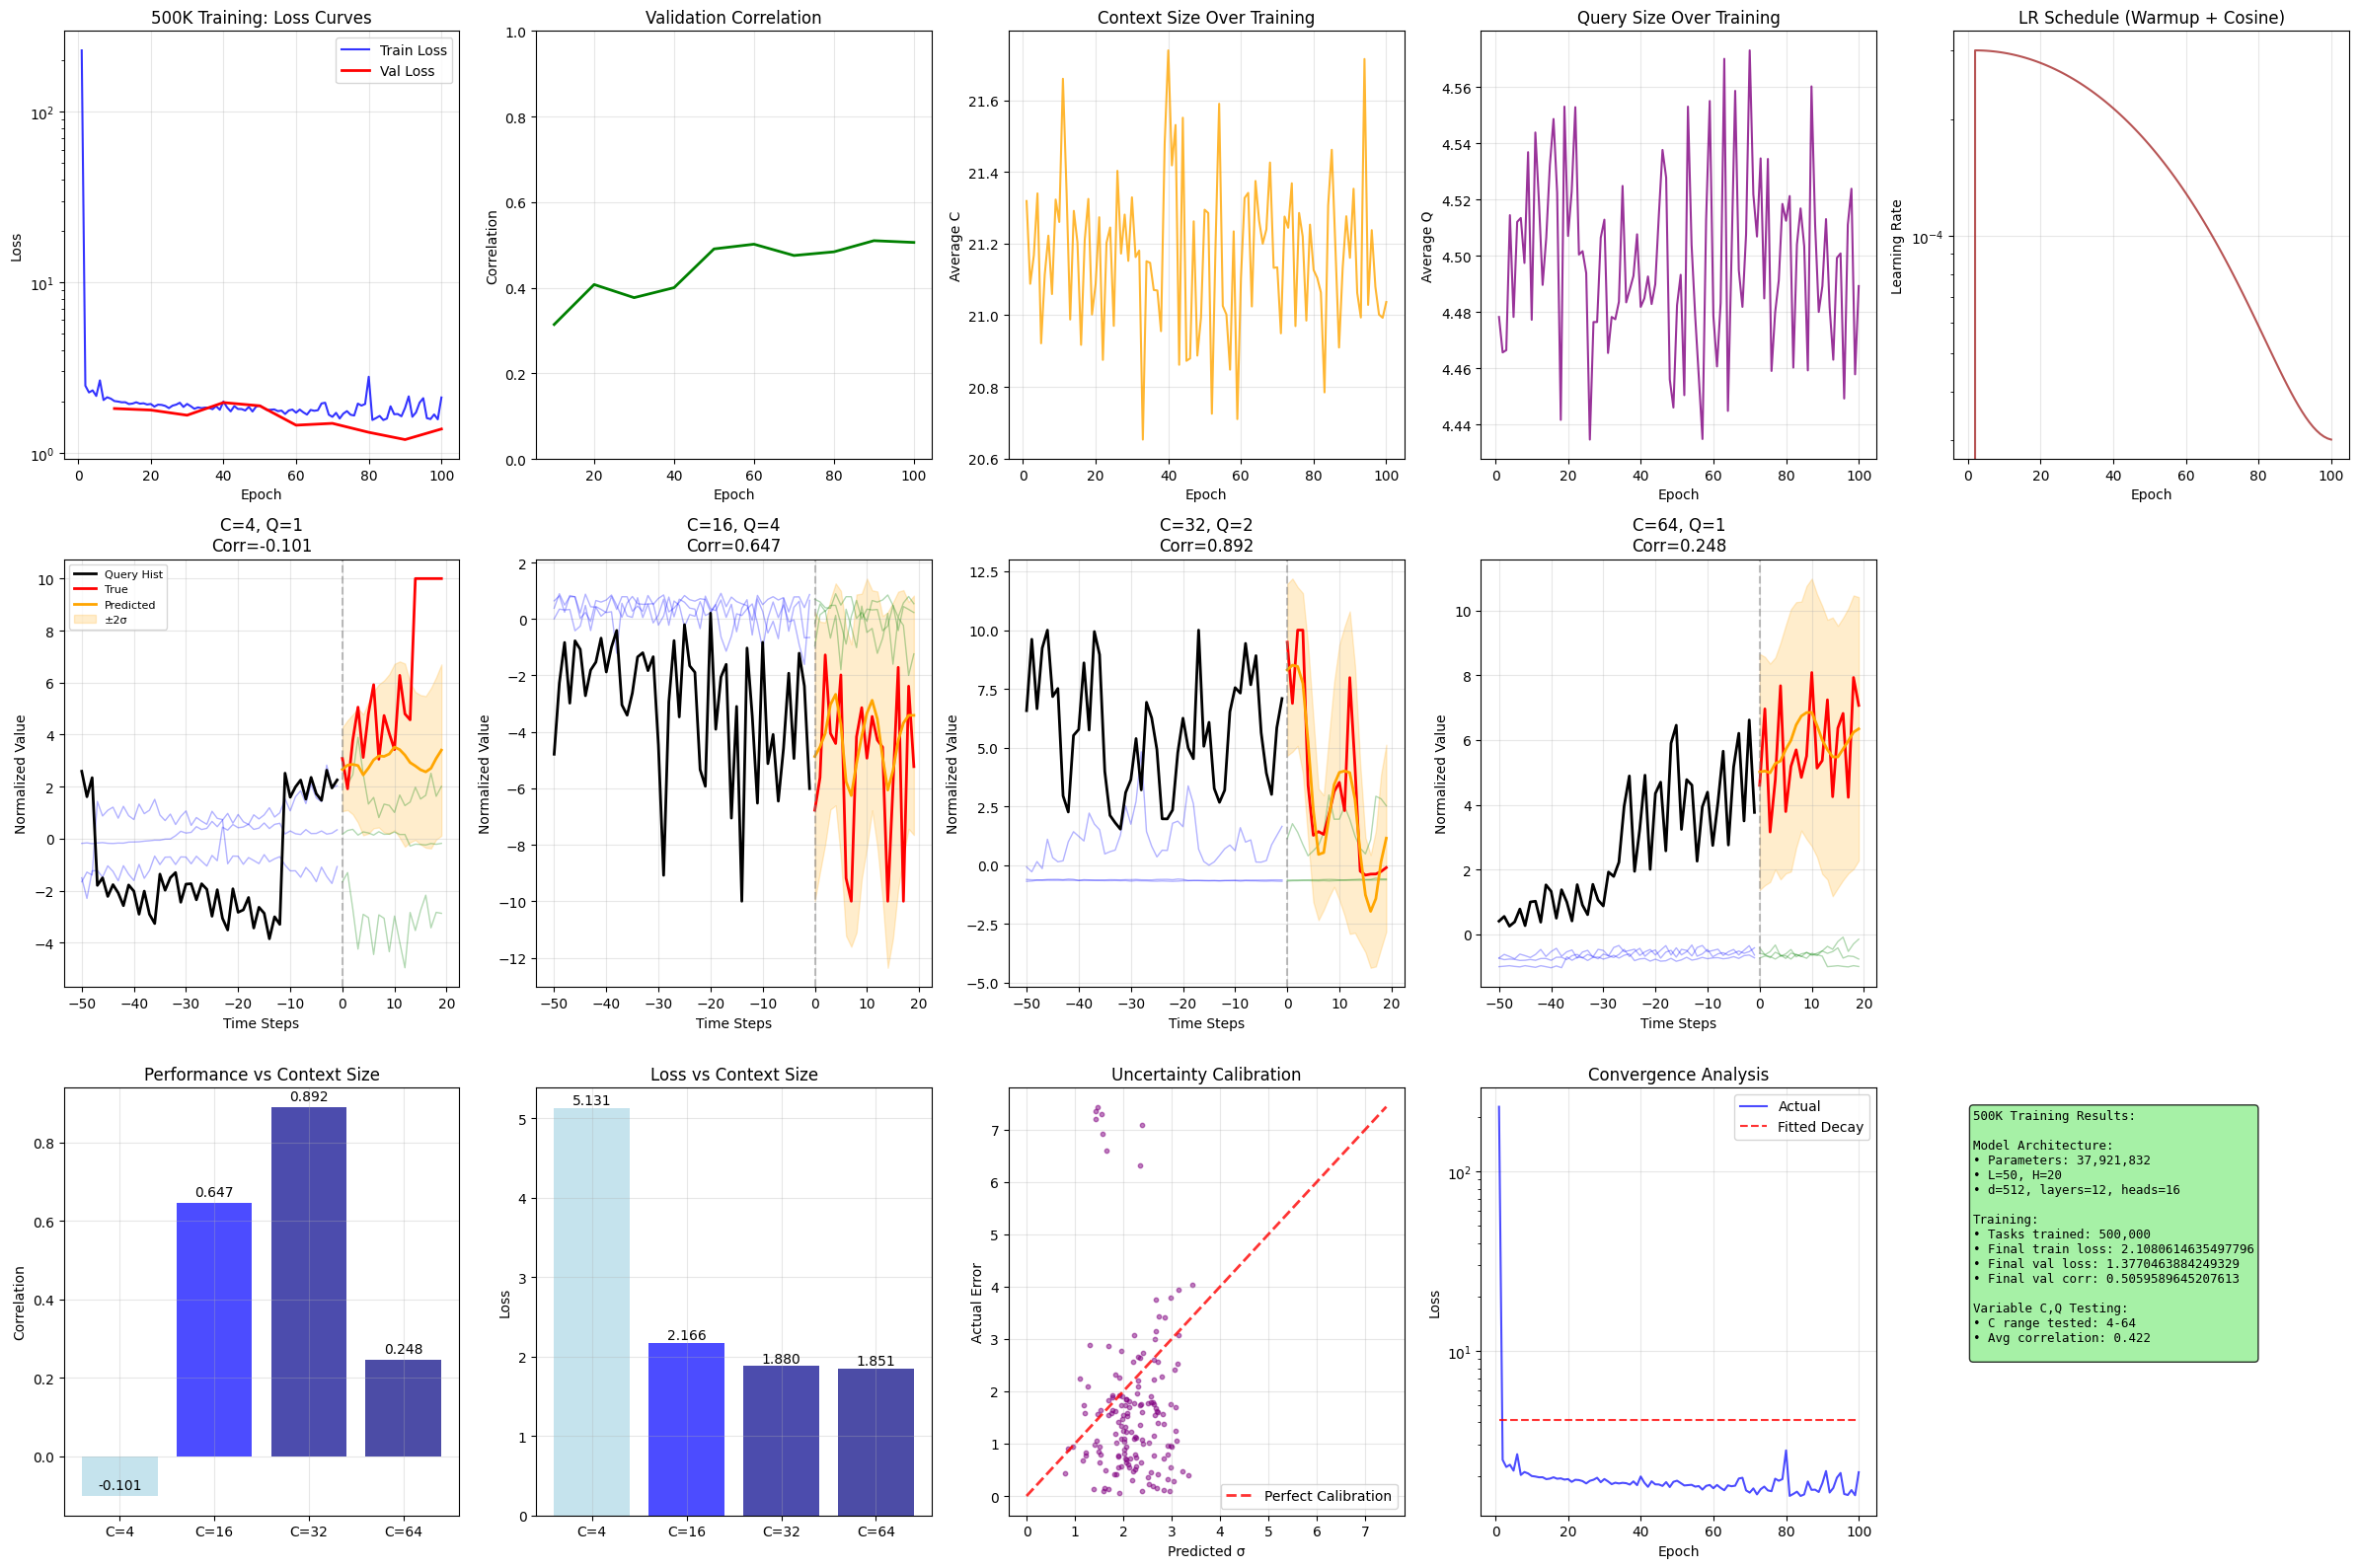


500K TRAINING ANALYSIS
Model: 37,921,832 parameters
Tasks trained: 500,000
Training speed: 180,009 tasks/hour
Best validation loss: 1.1935

 VARIABLE C,Q TEST RESULTS:
  C= 4, Q=1: Correlation=-0.101, Loss=5.1306
  C=16, Q=4: Correlation=0.647, Loss=2.1660
  C=32, Q=2: Correlation=0.892, Loss=1.8798
  C=64, Q=1: Correlation=0.248, Loss=1.8512


In [34]:
# ===== 500K TRAINING VISUALIZATION & ANALYSIS =====
plt.figure(figsize=(24, 16))

# Training curves
plt.subplot(3, 5, 1)
if scaled_history['loss']:
    plt.plot(scaled_history['epoch'], scaled_history['loss'], 'b-', label='Train Loss', alpha=0.8)
if 'val_loss' in scaled_history and scaled_history['val_loss']:
    plt.plot(scaled_history['val_epoch'], scaled_history['val_loss'], 'r-', label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('500K Training: Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Validation correlation over time
plt.subplot(3, 5, 2)
if 'val_correlation' in scaled_history and scaled_history['val_correlation']:
    plt.plot(scaled_history['val_epoch'], scaled_history['val_correlation'], 'g-', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Correlation')
    plt.title('Validation Correlation')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)

# Context size distribution over training
plt.subplot(3, 5, 3)
if scaled_history['avg_C']:
    plt.plot(scaled_history['epoch'], scaled_history['avg_C'], 'orange', alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Average C')
    plt.title('Context Size Over Training')
    plt.grid(True, alpha=0.3)

# Query size distribution over training
plt.subplot(3, 5, 4)
if scaled_history['avg_Q']:
    plt.plot(scaled_history['epoch'], scaled_history['avg_Q'], 'purple', alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Average Q')
    plt.title('Query Size Over Training')
    plt.grid(True, alpha=0.3)

# Learning rate schedule
plt.subplot(3, 5, 5)
if scaled_history['epoch']:
    # Approximate LR schedule
    total_steps = len(scaled_history['loss']) * scaled_config['tasks_per_epoch']
    lr_steps = np.arange(total_steps)
    lrs = []
    for step in lr_steps:
        if step < scaled_config['warmup_tasks']:
            lr = 3e-4 * step / scaled_config['warmup_tasks']
        else:
            progress = (step - scaled_config['warmup_tasks']) / (scaled_config['total_tasks'] - scaled_config['warmup_tasks'])
            lr = 3e-4 * (0.1 + 0.9 * 0.5 * (1 + np.cos(np.pi * progress)))
        lrs.append(lr)
    
    epoch_lrs = [lrs[i * scaled_config['tasks_per_epoch']] for i in range(len(scaled_history['epoch']))]
    plt.plot(scaled_history['epoch'], epoch_lrs, 'brown', alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('LR Schedule (Warmup + Cosine)')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

print("Generating test examples with variable C,Q sizes...")
model_scaled.eval()

# Generate test examples with different C,Q combinations
test_combinations = [
    (4, 1),    # Small context, single query
    (16, 4),   # Medium context, multiple queries
    (32, 2),   # Large context, few queries
    (64, 1),   # Very large context, single query (extrapolation)
]

test_results = []
for i, (C_test, Q_test) in enumerate(test_combinations):
    # Create custom dataset for this C,Q
    dataset_test = VariableMetaDataset(
        shape_config=shape_config,
        hyperprior_params=hyperprior_params,
        L=dataset_variable.L, H=dataset_variable.H,
        C_range=C_test, Q_range=Q_test,  # Fixed sizes
        device=device
    )
    
    task = dataset_test.create_meta_task()
    
    ctx_x = task['ctx_x'].unsqueeze(0).float().to(device)
    ctx_z = task['ctx_z'].unsqueeze(0).float().to(device)
    qry_x = task['qry_x'].unsqueeze(0).float().to(device)
    qry_z = task['qry_z'].unsqueeze(0).float().to(device)
    
    with torch.no_grad():
        mu, log_sigma2 = model_scaled(ctx_x, ctx_z, qry_x)
        sigma = torch.exp(0.5 * log_sigma2)
        loss = gaussian_nll_loss(mu, log_sigma2, qry_z)
    
    # Calculate correlation
    mu_flat = mu.flatten().cpu()
    qry_z_flat = qry_z.flatten().cpu()
    corr = torch.corrcoef(torch.stack([mu_flat, qry_z_flat]))[0, 1]
    
    test_results.append({
        'C': C_test, 'Q': Q_test, 'task': task,
        'mu': mu, 'sigma': sigma, 'qry_z': qry_z,
        'loss': loss.item(), 'correlation': corr.item() if not torch.isnan(corr) else 0
    })
    
    # Visualize this test case
    plt.subplot(3, 5, 6 + i)
    
    hist_points = np.arange(-dataset_variable.L, 0)
    fore_points = np.arange(0, dataset_variable.H)
    
    # Show a few context examples
    ctx_x_cpu = task['ctx_x'].cpu()
    ctx_z_cpu = task['ctx_z'].cpu()
    n_show = min(3, C_test)
    for j in range(n_show):
        alpha = 0.3 if n_show > 1 else 0.6
        plt.plot(hist_points, ctx_x_cpu[j], 'b-', alpha=alpha, linewidth=1)
        plt.plot(fore_points, ctx_z_cpu[j], 'g-', alpha=alpha, linewidth=1)
    
    # Show query (first one if multiple)
    qry_idx = 0
    qry_x_cpu = task['qry_x'][qry_idx].cpu()
    qry_z_true = task['qry_z'][qry_idx].cpu()
    qry_pred = mu[0, qry_idx].cpu()
    qry_std = sigma[0, qry_idx].cpu()
    
    plt.plot(hist_points, qry_x_cpu, 'k-', linewidth=2, label='Query Hist')
    plt.plot(fore_points, qry_z_true, 'r-', linewidth=2, label='True')
    plt.plot(fore_points, qry_pred, 'orange', linewidth=2, label='Predicted')
    plt.fill_between(fore_points, qry_pred - 2*qry_std, qry_pred + 2*qry_std, 
                     alpha=0.2, color='orange', label='±2σ')
    
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.xlabel('Time Steps')
    plt.ylabel('Normalized Value')
    plt.title(f'C={C_test}, Q={Q_test}\nCorr={corr:.3f}')
    if i == 0:
        plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)

# Performance comparison across C,Q sizes
plt.subplot(3, 5, 11)
C_sizes = [r['C'] for r in test_results]
correlations = [r['correlation'] for r in test_results]
colors = ['lightblue', 'blue', 'darkblue', 'navy']
bars = plt.bar([f"C={c}" for c in C_sizes], correlations, color=colors, alpha=0.7)
plt.ylabel('Correlation')
plt.title('Performance vs Context Size')
plt.grid(True, alpha=0.3)
for bar, corr in zip(bars, correlations):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{corr:.3f}', ha='center', va='bottom', fontsize=10)

# Loss comparison
plt.subplot(3, 5, 12)
losses = [r['loss'] for r in test_results]
bars = plt.bar([f"C={c}" for c in C_sizes], losses, color=colors, alpha=0.7)
plt.ylabel('Loss')
plt.title('Loss vs Context Size')
plt.grid(True, alpha=0.3)
for bar, loss in zip(bars, losses):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{loss:.3f}', ha='center', va='bottom', fontsize=10)

# Uncertainty calibration
plt.subplot(3, 5, 13)
all_sigmas = torch.cat([r['sigma'].flatten().cpu() for r in test_results])
all_errors = torch.cat([torch.abs(r['mu'].flatten().cpu() - r['qry_z'].flatten().cpu()) for r in test_results])
plt.scatter(all_sigmas, all_errors, alpha=0.5, s=10, color='purple')
max_val = max(all_sigmas.max(), all_errors.max())
plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.8, linewidth=2, label='Perfect Calibration')
plt.xlabel('Predicted σ')
plt.ylabel('Actual Error')
plt.title('Uncertainty Calibration')
plt.legend()
plt.grid(True, alpha=0.3)

# Training efficiency analysis
plt.subplot(3, 5, 14)
if scaled_history['loss']:
    # Show convergence rate
    train_losses = scaled_history['loss']
    epochs = scaled_history['epoch']
    
    # Fit exponential decay to see convergence
    if len(train_losses) > 10:
        from scipy.optimize import curve_fit
        def exp_decay(x, a, b, c):
            return a * np.exp(-b * x) + c
        
        try:
            popt, _ = curve_fit(exp_decay, epochs, train_losses, maxfev=1000)
            fitted = exp_decay(np.array(epochs), *popt)
            plt.plot(epochs, train_losses, 'b-', alpha=0.7, label='Actual')
            plt.plot(epochs, fitted, 'r--', alpha=0.8, label='Fitted Decay')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Convergence Analysis')
            plt.legend()
            plt.yscale('log')
        except:
            plt.plot(epochs, train_losses, 'b-', alpha=0.7)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training Loss')
            plt.yscale('log')
    else:
        plt.text(0.5, 0.5, 'Need more\ntraining data', ha='center', va='center', transform=plt.gca().transAxes)
    plt.grid(True, alpha=0.3)

# Model summary and results
plt.subplot(3, 5, 15)
plt.axis('off')

# Calculate final metrics
final_train_loss = scaled_history['loss'][-1] if scaled_history['loss'] else 'N/A'
final_val_loss = scaled_history['val_loss'][-1] if 'val_loss' in scaled_history and scaled_history['val_loss'] else 'N/A'
final_corr = scaled_history['val_correlation'][-1] if 'val_correlation' in scaled_history and scaled_history['val_correlation'] else 'N/A'
avg_test_corr = np.mean([r['correlation'] for r in test_results])

summary_text = f"""500K Training Results:

Model Architecture:
• Parameters: {scaled_params:,}
• L={dataset_variable.L}, H={dataset_variable.H}
• d=512, layers=12, heads=16

Training:
• Tasks trained: {global_task_count:,}
• Final train loss: {final_train_loss}
• Final val loss: {final_val_loss}
• Final val corr: {final_corr}

Variable C,Q Testing:
• C range tested: 4-64
• Avg correlation: {avg_test_corr:.3f}
"""

plt.text(0.05, 0.95, summary_text, transform=plt.gca().transAxes, 
         verticalalignment='top', fontfamily='monospace', fontsize=9,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.8))

plt.tight_layout()
plt.show()

# Print comprehensive results
print(f"\n500K TRAINING ANALYSIS")
print(f"Model: {scaled_params:,} parameters")
print(f"Tasks trained: {global_task_count:,}")
if total_time > 0:
    print(f"Training speed: {global_task_count / (total_time/3600):,.0f} tasks/hour")
print(f"Best validation loss: {best_val_loss:.4f}")

print(f"\n VARIABLE C,Q TEST RESULTS:")
for result in test_results:
    C, Q = result['C'], result['Q']
    corr, loss = result['correlation'], result['loss']
    print(f"  C={C:2d}, Q={Q}: Correlation={corr:.3f}, Loss={loss:.4f}")

In [35]:
model_scaled

SimpleLinearPFN(
  (phi_ctx): Linear(in_features=70, out_features=512, bias=True)
  (phi_qry): Linear(in_features=70, out_features=512, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_head): Linear(in_features=512, out_features=40, bias=True)
)